In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
random_yr = calc_temps('2016-01-01', '2017-01-01')
random_yr

[(56.0, 74.1317494600432, 84.0)]

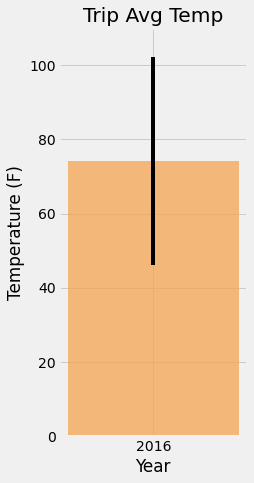

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Set parameters
x = '2016'
y_avg = random_yr[0][1]
y_min = random_yr[0][0]
y_max = random_yr[0][2]
y_err = y_max - y_min

# Plot and show the graph
plt.figure(figsize=(3,7))
plt.bar(x, y_avg, yerr=y_err, color='#F6A452', alpha=0.75)
plt.title('Trip Avg Temp')
plt.ylabel('Temperature (F)')
plt.xlabel('Year')
plt.ylim(0, 110)
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# My trip dates
trip_date = dt.date(2015, 2 ,1)
end_trip_date = dt.date(2015, 2 ,15)

# Yr back from my trip dates
start_yr_prior_trip = (trip_date - dt.timedelta(days=365)).strftime('%Y-%m-%d')
end_yr_prior_trip = (end_trip_date - dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Get the needed data of the rainfall amount per weather station from 'Measurement'
prcp_by_stations = (session.query(Measurement.station, func.sum(Measurement.prcp)).
                    filter(Measurement.date >= start_yr_prior_trip).filter(Measurement.date <= end_yr_prior_trip).
                    group_by(Measurement.station).
                    order_by(func.sum(Measurement.prcp).desc()).all())

# Get the needed data of the stations information from 'Station'
stations_info = (session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).
                 group_by(Station.station).all())

# Convert the data into DataFrames
prcp_by_stations_df = pd.DataFrame(prcp_by_stations, columns=['Station', 'Precipitation'])
stations_info_df = pd.DataFrame(stations_info, columns=['Station', 'Name', 'Latitude', 'Longitude', 'Elevation'])

# Merge the DataFrames into ONE DataFrame to deliver the Result 
merged_df = pd.merge(prcp_by_stations_df, stations_info_df, on='Station', how='inner')
merged_df

,Station,Precipitation,Name,Latitude,Longitude,Elevation
0,USC00519523,6.62,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
1,USC00516128,5.35,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
2,USC00519281,4.77,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,USC00513117,3.58,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,USC00514830,1.81,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519397,1.45,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00511918,0.96,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
7,USC00517948,0.35,"PEARL CITY, HI US",21.39340,-157.97510,11.9
8,USC00518838,0.00,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6


### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'


# Use the start and end date to create a range of dates
start_date_formatted = datetime.strptime(start_date, "%Y-%m-%d")
end_date_formatted = datetime.strptime(end_date, "%Y-%m-%d")

date_list = []

# Get the number of days
period_in_days = end_date_formatted - start_date_formatted
num_of_days = period_in_days.days

# Get the list of dates and store them to the empty 'date_list' above
for x in range(0, num_of_days +1):
    date_list.append(start_date_formatted + dt.timedelta(days=x))


# Strip off the year and save a list of strings in the format %m-%d
date_list_no_year = []

for x in date_list:
    date_list_no_year.append(x.strftime('%m-%d'))
    

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []

for x in date_list_no_year:
    results = daily_normals(x)
    normals.append(results[0])

In [15]:
#Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates_df = pd.DataFrame(normals, columns =['Min Tem', 'Avg Temp', 'Max Temp'])
trip_dates_df['Days'] = date_list_no_year 
trip_dates_df['DATE'] = date_list
trip_dates_df = trip_dates_df.set_index('DATE') 
trip_dates_df

,Min Tem,Avg Temp,Max Temp,Days
DATE,,,,
2017-08-01,67.0,75.540000,83.0,08-01
2017-08-02,68.0,75.603774,84.0,08-02
2017-08-03,70.0,76.611111,85.0,08-03
2017-08-04,69.0,76.711538,84.0,08-04
2017-08-05,69.0,76.148148,82.0,08-05
2017-08-06,67.0,76.250000,83.0,08-06
2017-08-07,71.0,77.156863,83.0,08-07


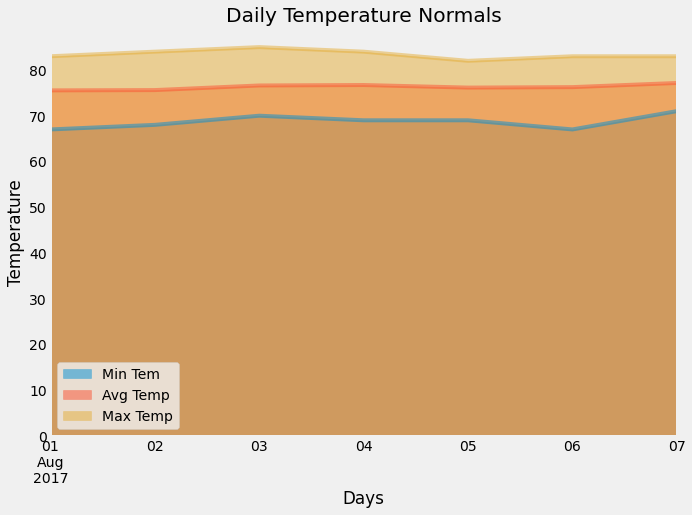

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
trip_dates_df.plot.area(stacked=False, figsize=(10,7))
plt.grid(color='#9FA095', alpha=1)
plt.title('Daily Temperature Normals')
plt.xlabel('Days')
plt.ylabel('Temperature')
plt.show()

## Close Session

In [17]:
# Close Session
session.close()